In [1]:
import arcpy
from arcpy import env
from arcpy.sa import *
arcpy.overwriteoutput = True

env.workspace = "F:\DriversFireProject\TEMP"

In [2]:
import requests
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import lxml.html as lh
import pandas as pd
import urllib
import time
from datetime import datetime, date, time, timedelta
import io
import requests
import zipfile
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
def shpFiles(rootPath, ext):
    emptyList = []
    root = rootPath
    for path, subdirs, files in os.walk(root):
        for names in files: 
            if names.endswith(ext) and not names.startswith("._"):
                emptyList.append(path + '\\' + names)
    return(emptyList)

In [4]:
ignitionFiles = shpFiles(r'F:\DriversFireProject\Ignition\Centroid', '.shp')
USFSIgnition = r'F:\DriversFireProject\Ignition\USFS_Ignitions\Ignition12_15.shp'
dateCSV = pd.read_csv(r'F:\DriversFireProject\NaturalNeighborResults\FinalDF.csv', index_col=0)
dateCSV.head()

,Fire,Area(ha),Year,JD_A,JD_B,PT_A,PT_B,direction,distance,Total Days,Total Area(ha),Ratio,cumsum,FID_ca_eco,EcoRegion
0,Bagleycomplex,283.020268,2012,0,231,"(40.9909947772, -122.072186413)","(41.0053171596, -122.043491753)",56.512489,2.887099,23,18603.344336,0.015213,0.015213,7,Klamath Mountains
1,Bagleycomplex,697.831159,2012,231,232,"(41.0053171596, -122.043491753)","(41.0090568338, -122.04037631799999)",32.155006,0.491179,23,18603.344336,0.037511,0.052724,7,Klamath Mountains
2,Bagleycomplex,813.693831,2012,232,233,"(41.0090568338, -122.04037631799999)","(41.0078275693, -122.03882670799999)",136.430234,0.188654,23,18603.344336,0.043739,0.096464,7,Klamath Mountains
3,Bagleycomplex,858.176194,2012,233,234,"(41.0078275693, -122.03882670799999)","(41.0066959359, -122.042133041)",245.604318,0.304639,23,18603.344336,0.046130,0.142594,7,Klamath Mountains
4,Bagleycomplex,957.232491,2012,234,235,"(41.0066959359, -122.042133041)","(41.0064471794, -122.045402632)",264.243995,0.275747,23,18603.344336,0.051455,0.194049,7,Klamath Mountains


In [5]:
# get start dates 
idx = dateCSV.groupby(['Fire', 'Year'])['JD_B'].transform(min) == dateCSV['JD_B']
firstDay = dateCSV[idx]
firstDay

,Fire,Area(ha),Year,JD_A,JD_B,PT_A,PT_B,direction,distance,Total Days,Total Area(ha),Ratio,cumsum,FID_ca_eco,EcoRegion
0,Bagleycomplex,283.020268,2012,0,231,"(40.9909947772, -122.072186413)","(41.0053171596, -122.043491753)",56.512489,2.887099,23,18603.344336,0.015213,0.015213,7,Klamath Mountains
13,Chihuahua2,654.516826,2012,0,222,"(33.3899951375, -116.73738812299999)","(33.389015576300004, -116.721109835)",94.117781,1.515230,2,811.999473,0.806056,0.806056,8,Southern and Baja California Pine-Oak Mountains
15,Chips,8.547429,2012,0,210,"(40.0136947864, -121.281386675)","(40.0123917031, -121.279776359)",136.574578,0.199506,39,30502.951030,0.000280,0.000280,4,Sierra Nevada
41,Dale,634.334939,2012,0,187,"(40.4773948489, -122.462886429)","(40.4928579746, -122.48575698100001)",311.643019,2.587967,1,634.334939,1.000000,1.000000,5,"California Coastal Sage, Chaparral, and Oak Wo..."
42,Fortcomplex,32.608304,2012,0,221,"(41.8911948174, -123.255886095)","(41.8867219748, -123.257937365)",198.850813,0.525544,37,8993.417018,0.003626,0.003626,7,Klamath Mountains
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322,Sand,641.878821,2019,0,159,"(38.9324824598, -122.25583180100004)","(38.9112006658, -122.255994089)",180.339971,2.366469,2,896.266551,0.716170,0.716170,5,"California Coastal Sage, Chaparral, and Oak Wo..."
2324,South,322.933773,2019,0,248,"(40.1084899023, -122.788911432)","(40.1077254894, -122.79211786299999)",252.688617,0.285632,33,2162.009260,0.149367,0.149367,7,Klamath Mountains
2332,Springs,0.071594,2019,0,214,"(37.8285797941, -118.87369234)","(37.8292790221, -118.87605664600001)",290.528235,0.221728,32,1956.975518,0.000037,0.000037,4,Sierra Nevada
2366,Tucker,1306.829942,2019,0,209,"(41.755130181700004, -121.270354059)","(41.7539556679, -121.270515836)",185.866853,0.131288,3,5306.963977,0.246248,0.246248,3,Cascades


In [6]:
# Add attributes: FIRE_NAME, FIRE_YEAR, DISCOVERY_ (datetime) 

fire = [] 
year = [] 
julianDay = [] 
xcoord = [] 
ycoord = [] 

for ign in ignitionFiles: 
    nm = ign.split("\\")
    name = nm[-1]
    nmm = name.split("_")
    fr = nmm[0]
    yr = nmm[1]
    try:
        jd = firstDay.loc[(firstDay.Fire == fr) & (firstDay.Year == int(yr)), 'JD_B'].item()
        with arcpy.da.SearchCursor(ign, ['POINT_X', 'POINT_Y',]) as cursor:
            for row in cursor:
                xcoord.append(row[0])
                ycoord.append(row[1])
                fire.append(fr) 
                year.append(yr) 
                julianDay.append(jd)
                print(yr, fr, jd, row[0], row[1])
    except: 
        print("error", fr, yr)
        continue
            
ignitionDF = pd.DataFrame({'Fire': fire, 'Year': year,'JulianDay': julianDay, 
                       'X': xcoord, 'Y': ycoord})
ignitionDF

C:\Users\erica\AppData\Local\ESRI\conda\envs\my_arcgispro-py3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: `item` has been deprecated and will be removed in a future version
  app.launch_new_instance()


2017 Adobe 281 -122.551709092 38.426743736
2017 Alamo 188 -120.298274318 35.014525164
2018 Alder 289 -118.620627554 36.2112549374
2013 American 223 -120.645886895 39.1165648096
2013 Aspen 203 -119.324387326 37.2870948781
2017 Atlas 281 -122.282859661 38.392271876
2012 Bagleycomplex 231 -122.072186413 40.9909947772
error Banner 2012
2014 Basilonecomplexcombat 136 -117.553924231 33.4145323408
2014 Basilonecomplexpulgas 134 -117.333988023 33.3467951742
2014 Basilonecomplextomahawk 134 -117.279289834 33.3699732256
2017 Berry 255 -121.825062103 40.9803314864
2016 Bluecut 229 -117.482429718 34.2926409886
error Boot 2018
2016 Border3 171 -116.634288198 32.6049952264
error Briceburg 2019
2017 Buck 256 -123.036571378 40.2275199137
2014 Bully 192 -122.775730156 40.4364582472
2017 Burney 234 -123.316166139 41.555694845
2013 Butler 212 -123.382386165 41.3251948667
2014 Butts 182 -122.446395664 38.6652146387
2015 Cabinanf 226 -117.853290451 34.2582223593
2015 Cabinsqf 210 -118.571087559 36.25049493

2013 Panther 115 -121.597906602 40.1900947981
2017 Parker2 215 -120.324396619 41.4619745908
error Parkhill 2015
2017 Park 198 -120.486206217 36.0300463141
2017 Partrick 282 -122.373715464 38.2769981134
2012 Pass 231 -123.133286415 39.8631949498
2018 Pawnee 174 -122.6030351 39.0910636345
2017 Pier 241 -118.671287551 36.1673949458
2016 Pilot 220 -117.269866657 34.285551369
2016 Pine 182 -119.226954259 34.6286647302
2012 Piutecomplexclear 217 -118.464452647 35.5256924986
error Pleasant 2018
2017 Pocket 282 -122.904993843 38.7652249001
2017 Ponderosa 241 -121.278750107 39.5741360731
2016 Pony 159 -123.551646095 41.6205548613
2013 Powerhouse 150 -118.447337732 34.6134450946
2017 Prescott 220 -123.635556065 41.7334948616
2019 R1ranch 239 -120.539506717 40.5581346815
2017 Railroad 241 -119.652415105 37.4557393216
2012 Ramsey 224 -120.164987063 38.3825948375
2019 Ranch 307 -122.6276507 40.063109023
2012 Reading 215 -121.45604658 40.4956447624
2019 Redbank 248 -122.630203614 40.1233401314
error

,Fire,Year,JulianDay,X,Y
0,Adobe,2017,281,-122.551709,38.426744
1,Alamo,2017,188,-120.298274,35.014525
2,Alder,2018,289,-118.620628,36.211255
3,American,2013,223,-120.645887,39.116565
4,Aspen,2013,203,-119.324387,37.287095
...,...,...,...,...,...
252,Winter,2017,187,-122.055661,38.517883
253,Woolsey,2018,312,-118.740933,34.213081
254,Wragg,2015,203,-122.068092,38.480654
255,Wye,2012,225,-122.432599,39.015616


In [7]:
ignitionDF.to_csv(r"F:\DriversFireProject\Ignition\ignitionDF.csv")

In [32]:
# Process: Convert Table To CSV File
arcpy.TableToTable_conversion(USFSIgnition, r"F:\DriversFireProject\Ignition", "USFSIgnitions.csv")

<Result 'F:\\DriversFireProject\\Ignition\\USFSIgnitions.csv'>

In [8]:
USFS_CSV = pd.read_csv(r'F:\DriversFireProject\Ignition\USFSIgnitions.csv', index_col=0)
USFS_CSV

,FOD_ID,FPA_ID,SOURCE_SYS,SOURCE_S_1,NWCG_REPOR,NWCG_REP_1,NWCG_REP_2,SOURCE_REP,SOURCE_R_1,LOCAL_FIRE,...,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESC,STATE,COUNTY,FIPS_CODE,FIPS_NAME,POINT_X,POINT_Y
FID,,,,,,,,,,,,,,,,,,,,,
0,201433475,FS-1507616,FED,FS-FIRESTAT,FS,USNVHTF,Humboldt-Toiyabe National Forest,0417,Toiyabe National Forest,072,...,39.445556,-120.027500,5.0,USFS,CA,091,091,Sierra,-120.027500,39.445556
1,201433482,FS-1506661,FED,FS-FIRESTAT,FS,USNVHTF,Humboldt-Toiyabe National Forest,0417,Toiyabe National Forest,046,...,38.732778,-119.956389,5.0,USFS,CA,003,003,Alpine,-119.956389,38.732778
2,201433485,FS-1505963,FED,FS-FIRESTAT,FS,USNVHTF,Humboldt-Toiyabe National Forest,0417,Toiyabe National Forest,013,...,38.699167,-119.982500,13.0,STATE OR PRIVATE,CA,003,003,Alpine,-119.982500,38.699167
3,201433486,FS-1506071,FED,FS-FIRESTAT,FS,USNVHTF,Humboldt-Toiyabe National Forest,0417,Toiyabe National Forest,024,...,38.321111,-119.522222,5.0,USFS,CA,051,051,Mono,-119.522222,38.321111
4,201433487,FS-1506078,FED,FS-FIRESTAT,FS,USNVHTF,Humboldt-Toiyabe National Forest,0417,Toiyabe National Forest,027,...,38.236389,-119.579444,5.0,USFS,CA,051,051,Mono,-119.579444,38.236389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29785,300348363,2015CAIRS29019636,NONFED,ST-CACDF,ST/C&L,USCASHU,Shasta-Trinity Unit,CASHU,Shasta-Trinity Unit,591814,...,40.481637,-122.389375,13.0,STATE OR PRIVATE,CA,,,,-122.389375,40.481637
29786,300348373,2015CAIRS29217935,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,569419,...,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,,,,-120.938570,37.617619
29787,300348375,2015CAIRS28364460,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,574245,...,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,,,,-120.938570,37.617619


In [9]:
USFS_CSV.dtypes

FOD_ID          int64
FPA_ID         object
SOURCE_SYS     object
SOURCE_S_1     object
NWCG_REPOR     object
NWCG_REP_1     object
NWCG_REP_2     object
SOURCE_REP     object
SOURCE_R_1     object
LOCAL_FIRE     object
LOCAL_INCI     object
FIRE_CODE      object
FIRE_NAME      object
ICS_209_IN     object
ICS_209_NA     object
MTBS_ID        object
MTBS_FIRE_     object
COMPLEX_NA     object
FIRE_YEAR       int64
DISCOVERY_     object
DISCOVERY1      int64
DISCOVER_1     object
STAT_CAUSE    float64
STAT_CAU_1     object
CONT_DATE      object
CONT_DOY        int64
CONT_TIME      object
FIRE_SIZE     float64
FIRE_SIZE_     object
LATITUDE      float64
LONGITUDE     float64
OWNER_CODE    float64
OWNER_DESC     object
STATE          object
COUNTY         object
FIPS_CODE      object
FIPS_NAME      object
POINT_X       float64
POINT_Y       float64
dtype: object

In [39]:
import difflib

In [10]:
# pip install fuzzywuzzy
from fuzzywuzzy import fuzz

def match_name(name, list_names, min_score=0):
    # -1 score incase we don't get any matches
    max_score = -1
    # Returning empty name for no match as well
    max_name = ""
    # Iternating over all names in the other
    for name2 in list_names:
        #Finding fuzzy match score
        score = fuzz.ratio(name, name2)
        # Checking if we are above our threshold and have a better score
        if (score > min_score) & (score > max_score):
            max_name = name2
            max_score = score
    return (max_name, max_score)

In [14]:
ignitionDF['Year'].astype('int64')
ignitionDF = ignitionDF[ignitionDF['Year'].astype('int64') < 2016]

In [85]:
# List for dicts for easy dataframe creation
dict_list = []
# iterating over our players without salaries found above
for name in ignitionDF.Fire:
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, listUSFS, 70)
    
    # New dict for storing data
    dict_ = {}
    dict_.update({"FireName" : name})
    dict_.update({"USFS Name" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)
    
merge_table = pd.DataFrame(dict_list)
# Display results
merge_table

,FireName,USFS Name,score
0,American,American,100
1,Aspen,Aspen,100
2,Bagleycomplex,Bagley complex,96
3,Combat,Combat,100
4,Pulgas,Pulgas,100
...,...,...,...
106,White,White,100
107,Williams,Williams,100
108,Willow,Willow,100
109,Wragg,Wragg,100


In [88]:
listUSFS = USFS_CSV.FIRE_NAME.tolist()
listUSFS

listUSFS = [x.capitalize() for x in listUSFS]
listUSFS
USFS_CSV['Fire']= listUSFS

In [ ]:
listUSFS[listUSFS[]]

In [86]:
NonMatch = merge_table[merge_table['score'] == -1]
NonMatchList = NonMatch.FireName.tolist()
NonMatchList

['Fryingpan Faulkstein']

In [83]:
newNames = ['Coffee', 'Fryingpan Faulkstein','Steelhead', 'Md Flake', 'Clear', 'Buck', 'Pelletreau']

In [73]:
newNames = ['combat',
 'pulgas',
 'tomahawk',
 'corral',
 'barker',
 'blue',
 'peak',
 'rail',
 'shiell',
 'bear',
 'coon',
 'peak',
 'fryingpan faulkstein',
 'fryingpan',
 'log',
 'man',
 'whites',
 'gobbler',
 'lassics',
 'pickett',
 'gulch',
 'johnson',
 'boulder',
 'shelly',
 'cocos']

newNames = [x.title() for x in newNames]
newNames

['Combat',
 'Pulgas',
 'Tomahawk',
 'Corral',
 'Barker',
 'Blue',
 'Peak',
 'Rail',
 'Shiell',
 'Bear',
 'Coon',
 'Peak',
 'Fryingpan Faulkstein',
 'Fryingpan',
 'Log',
 'Man',
 'Whites',
 'Gobbler',
 'Lassics',
 'Pickett',
 'Gulch',
 'Johnson',
 'Boulder',
 'Shelly',
 'Cocos']

In [84]:
ignitionDF = ignitionDF.replace(NonMatchList, newNames)

In [87]:
ignitionDF

,Fire,Year,JulianDay,X,Y
3,American,2013,223,-120.645887,39.116565
4,Aspen,2013,203,-119.324387,37.287095
6,Bagleycomplex,2012,231,-122.072186,40.990995
7,Combat,2014,136,-117.553924,33.414532
8,Pulgas,2014,134,-117.333988,33.346795
...,...,...,...,...,...
247,White,2013,147,-119.797540,34.543981
250,Williams,2012,246,-117.801388,34.231195
251,Willow,2015,206,-119.501187,37.275895
254,Wragg,2015,203,-122.068092,38.480654


In [93]:
ignitionDF

,Fire,Year,JulianDay,X,Y
3,American,2013,223,-120.645887,39.116565
4,Aspen,2013,203,-119.324387,37.287095
6,Bagleycomplex,2012,231,-122.072186,40.990995
7,Combat,2014,136,-117.553924,33.414532
8,Pulgas,2014,134,-117.333988,33.346795
...,...,...,...,...,...
247,White,2013,147,-119.797540,34.543981
250,Williams,2012,246,-117.801388,34.231195
251,Willow,2015,206,-119.501187,37.275895
254,Wragg,2015,203,-122.068092,38.480654


In [99]:
am = USFS_CSV[USFS_CSV['Fire'] =='American']
am['DISCOVERY1']

FID
1259     199
3162     292
3173     326
4132     213
6858     222
9666     125
12291    193
12854    110
13381    179
15494    224
22111    248
23286     37
24891    273
25723    249
26138    229
28446    147
Name: DISCOVERY1, dtype: int64

In [109]:
ignitionDF['JulianDay'] = ignitionDF['JulianDay'].astype('int64')
ignitionDF['Year'] = ignitionDF['Year'].astype('int64')
mergedIgnition = pd.merge(ignitionDF, USFS_CSV, how='left', left_on=['Fire', 'Year'], right_on=['Fire', 'FIRE_YEAR'])

In [112]:
len(mergedIgnition['Fire'].unique())

82

In [102]:
mergedIgnition.to_csv(r'F:\DriversFireProject\Ignition\MergedIgnitions.csv')

In [111]:
mergedIgnition['dif'] = (mergedIgnition['JulianDay'] - mergedIgnition['DISCOVERY1']).abs()
mergedIgnition['is_closest'] = mergedIgnition.groupby(['Fire', 'Year'])['dif'].transform('min') == mergedIgnition['dif']
mergedIgnition = mergedIgnition[mergedIgnition['is_closest'] == True]
mergedIgnition.to_csv(r'F:\DriversFireProject\Ignition\MergedIgnitions_FILT.csv')

In [113]:
mergedIgnition

,Fire,Year,JulianDay,X,Y,FOD_ID,FPA_ID,SOURCE_SYS,SOURCE_S_1,NWCG_REPOR,...,OWNER_CODE,OWNER_DESC,STATE,COUNTY,FIPS_CODE,FIPS_NAME,POINT_X,POINT_Y,dif,is_closest
0,American,2013,223,-120.645887,39.116565,201760265.0,FS-1519193,FED,FS-FIRESTAT,FS,...,5.0,USFS,CA,061,061,Placer,-120.646111,39.118889,1.0,True
5,Aspen,2013,203,-119.324387,37.287095,201760991.0,FS-1518963,FED,FS-FIRESTAT,FS,...,5.0,USFS,CA,019,019,Fresno,-119.318056,37.278611,0.0,True
7,Combat,2014,136,-117.553924,33.414532,300150346.0,ICS209_2014_405755,INTERAGCY,IA-ICS209,DOD,...,14.0,MISSING/NOT SPECIFIED,CA,073,073,San Diego,-117.553611,33.421111,0.0,True
8,Pulgas,2014,134,-117.333988,33.346795,300150329.0,ICS209_2014_405786,INTERAGCY,IA-ICS209,DOD,...,14.0,MISSING/NOT SPECIFIED,CA,065,065,Riverside,-117.077222,33.571944,1.0,True
9,Tomahawk,2014,134,-117.279290,33.369973,300150324.0,ICS209_2014_400503,INTERAGCY,IA-ICS209,DOD,...,14.0,MISSING/NOT SPECIFIED,CA,073,073,San Diego,-117.263611,33.383056,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,White,2013,147,-119.797540,34.543981,201763175.0,FS-1514903,FED,FS-FIRESTAT,FS,...,5.0,USFS,CA,083,083,Santa Barbara,-119.801389,34.549167,0.0,True
264,Williams,2012,246,-117.801388,34.231195,201433915.0,FS-1508083,FED,FS-FIRESTAT,FS,...,5.0,USFS,CA,037,037,Los Angeles,-117.813056,34.238333,0.0,True
278,Willow,2015,206,-119.501187,37.275895,300320690.0,2015CAIRS27671921,NONFED,ST-CACDF,ST/C&L,...,13.0,STATE OR PRIVATE,CA,,,,-119.511139,37.262607,0.0,True
279,Wragg,2015,203,-122.068092,38.480654,300209181.0,W-686633,FED,DOI-WFMI,BLM,...,1.0,BLM,CA,Sonoma,097,Sonoma,-122.111542,38.505810,0.0,True


In [114]:
mergedIgnition = mergedIgnition.sort_values(["JulianDay"], ascending = True)
mergedIgnition['INT_XY'] = list(zip(mergedIgnition.Y, mergedIgnition.X))
mergedIgnition['USFS_XY'] = list(zip(mergedIgnition.POINT_Y, mergedIgnition.POINT_X))

In [115]:
mergedIgnition

,Fire,Year,JulianDay,X,Y,FOD_ID,FPA_ID,SOURCE_SYS,SOURCE_S_1,NWCG_REPOR,...,STATE,COUNTY,FIPS_CODE,FIPS_NAME,POINT_X,POINT_Y,dif,is_closest,INT_XY,USFS_XY
25,Colby,2014,16,-117.862617,34.156378,300000834.0,FS-1520216,FED,FS-FIRESTAT,FS,...,CA,Los Angeles,037,Los Angeles,-117.847778,34.165000,0.0,True,"(34.1563783018, -117.862617368)","(34.165, -117.84777778)"
182,Panther,2013,115,-121.597907,40.190095,201760820.0,FS-1513826,FED,FS-FIRESTAT,FS,...,CA,103,103,Tehama,-121.601944,40.188056,6.0,True,"(40.1900947981, -121.597906602)","(40.18805556, -121.60194444)"
48,Etiwanda,2014,120,-117.529012,34.173600,300150241.0,ICS209_2014_370417,INTERAGCY,IA-ICS209,FS,...,CA,071,071,San Bernardino,-117.549167,34.200833,0.0,True,"(34.1735997464, -117.529011973)","(34.2008333, -117.5491667)"
8,Pulgas,2014,134,-117.333988,33.346795,300150329.0,ICS209_2014_405786,INTERAGCY,IA-ICS209,DOD,...,CA,065,065,Riverside,-117.077222,33.571944,1.0,True,"(33.3467951742, -117.333988023)","(33.5719444, -117.0772222)"
9,Tomahawk,2014,134,-117.279290,33.369973,300150324.0,ICS209_2014_400503,INTERAGCY,IA-ICS209,DOD,...,CA,073,073,San Diego,-117.263611,33.383056,0.0,True,"(33.3699732256, -117.279289834)","(33.3830556, -117.2636111)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,Lumpkin,2015,254,-121.331634,39.521376,300335715.0,2015CAIRS28040121,NONFED,ST-CACDF,ST/C&L,...,CA,,,,-121.358559,39.507366,0.0,True,"(39.5213759378, -121.331633734)","(39.507366, -121.358559)"
148,Lumpkin,2015,254,-121.331634,39.521376,300206671.0,FS-6360139,FED,FS-FIRESTAT,FS,...,CA,007,007,Butte,-121.338611,39.519167,0.0,True,"(39.5213759378, -121.331633734)","(39.51916667, -121.33861111)"
142,King,2014,257,-120.596557,38.781245,300156672.0,ICS209_2014_983669,INTERAGCY,IA-ICS209,FS,...,CA,017,017,El Dorado,-120.602222,38.792500,1.0,True,"(38.7812448351, -120.596556945)","(38.7925, -120.6022222)"
153,Mccabe,2013,326,-122.808787,38.813195,201819224.0,SFO-2013CACDFLNU010188,NONFED,ST-NASF,ST/C&L,...,CA,SONOMA,097,Sonoma,-122.814950,38.805500,0.0,True,"(38.8131950022, -122.808786601)","(38.8055, -122.81495)"


In [117]:
import math
from math import radians, degrees, sin, cos, asin, acos, sqrt
def calculateDistance(pointA, pointB):
    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])
    lon1 = math.radians(pointA[1])
    lon2 = math.radians(pointB[1])
    return 6371 * (
        acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
    )

In [124]:
calculateDistance((34.1563783018, -117.862617368), (40.1900947981, -121.597906602))

747.911082551841

In [128]:
INTList = mergedIgnition.INT_XY.tolist()
USFSList = mergedIgnition.USFS_XY.tolist()

dist = [] 

for f, b in zip(INTList, USFSList):
    dist.append(calculateDistance(f, b))

mergedIgnition['Distance'] = dist
mergedIgnition

,Fire,Year,JulianDay,X,Y,FOD_ID,FPA_ID,SOURCE_SYS,SOURCE_S_1,NWCG_REPOR,...,COUNTY,FIPS_CODE,FIPS_NAME,POINT_X,POINT_Y,dif,is_closest,INT_XY,USFS_XY,Distance
25,Colby,2014,16,-117.862617,34.156378,300000834.0,FS-1520216,FED,FS-FIRESTAT,FS,...,Los Angeles,037,Los Angeles,-117.847778,34.165000,0.0,True,"(34.1563783018, -117.862617368)","(34.165, -117.84777778)",1.668346
182,Panther,2013,115,-121.597907,40.190095,201760820.0,FS-1513826,FED,FS-FIRESTAT,FS,...,103,103,Tehama,-121.601944,40.188056,6.0,True,"(40.1900947981, -121.597906602)","(40.18805556, -121.60194444)",0.411168
48,Etiwanda,2014,120,-117.529012,34.173600,300150241.0,ICS209_2014_370417,INTERAGCY,IA-ICS209,FS,...,071,071,San Bernardino,-117.549167,34.200833,0.0,True,"(34.1735997464, -117.529011973)","(34.2008333, -117.5491667)",3.550630
8,Pulgas,2014,134,-117.333988,33.346795,300150329.0,ICS209_2014_405786,INTERAGCY,IA-ICS209,DOD,...,065,065,Riverside,-117.077222,33.571944,1.0,True,"(33.3467951742, -117.333988023)","(33.5719444, -117.0772222)",34.556331
9,Tomahawk,2014,134,-117.279290,33.369973,300150324.0,ICS209_2014_400503,INTERAGCY,IA-ICS209,DOD,...,073,073,San Diego,-117.263611,33.383056,0.0,True,"(33.3699732256, -117.279289834)","(33.3830556, -117.2636111)",2.058075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,Lumpkin,2015,254,-121.331634,39.521376,300335715.0,2015CAIRS28040121,NONFED,ST-CACDF,ST/C&L,...,,,,-121.358559,39.507366,0.0,True,"(39.5213759378, -121.331633734)","(39.507366, -121.358559)",2.785983
148,Lumpkin,2015,254,-121.331634,39.521376,300206671.0,FS-6360139,FED,FS-FIRESTAT,FS,...,007,007,Butte,-121.338611,39.519167,0.0,True,"(39.5213759378, -121.331633734)","(39.51916667, -121.33861111)",0.646945
142,King,2014,257,-120.596557,38.781245,300156672.0,ICS209_2014_983669,INTERAGCY,IA-ICS209,FS,...,017,017,El Dorado,-120.602222,38.792500,1.0,True,"(38.7812448351, -120.596556945)","(38.7925, -120.6022222)",1.344399
153,Mccabe,2013,326,-122.808787,38.813195,201819224.0,SFO-2013CACDFLNU010188,NONFED,ST-NASF,ST/C&L,...,SONOMA,097,Sonoma,-122.814950,38.805500,0.0,True,"(38.8131950022, -122.808786601)","(38.8055, -122.81495)",1.008627


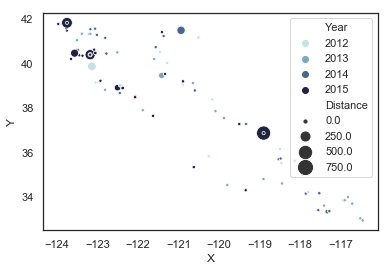

In [151]:
import seaborn as sns
sns.set(style="white")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
ax = sns.scatterplot(x="X", y="Y",
                     hue="Year", size="Distance",
                     palette=cmap, sizes=(10, 200),
                     data=mergedIgnition)

In [141]:
mergedIgnition['dif'].max()

39.0

In [185]:
mergedIgnition = mergedIgnition.sort_values(by=['Distance'])
mergedIgnition['Fire'].tolist()

['Clear',
 'Boulder',
 'Coffee',
 'Coon',
 'Bear',
 'Log',
 'Nickowitz',
 'Reading',
 'Turkey',
 'Gobbler',
 'American',
 'General',
 'Blue',
 'Ramsey',
 'French',
 'Butler',
 'Way',
 'Silver',
 'Shelly',
 'Rough',
 'Panther',
 'Day',
 'Falls',
 'Robbers',
 'George',
 'Elk',
 'Lumpkin',
 'White',
 'Butts',
 'Combat',
 'Shiell',
 'Barker',
 'Clover',
 'Rim',
 'Eiler',
 'Whites',
 'Corral',
 'Mccabe',
 'Morgan',
 'Solimar',
 'Grand',
 'Mountain',
 'Aspen',
 'Chips',
 'Pelletreau',
 'Chariot',
 'Shirley',
 'Man',
 'Frog',
 'Williams',
 'King',
 'Scotts',
 'Pickett',
 'Colby',
 'Willow',
 'Highland',
 'Peak',
 'Swedes',
 'Nicolls',
 'Tomahawk',
 'Tomahawk',
 'Hathaway',
 'Powerhouse',
 'Carstens',
 'Peak',
 'Lumpkin',
 'Monticello',
 'Steelhead',
 'Lowell',
 'Cuesta',
 'Etiwanda',
 'Johnson',
 'Bully',
 'Wragg',
 'Tesla',
 'Likely',
 'Rail',
 'Lassics',
 'Jerusalem',
 'Wye',
 'Blue',
 'Pulgas',
 'Peak',
 'Swedes',
 'Rocky',
 'Buck',
 'Gulch',
 'Pass',
 'Blue',
 'Bear',
 'Rough']

In [186]:
distList = mergedIgnition['Distance'].tolist()
sorted(distList)


[0.0519499968506098,
 0.08190248131211031,
 0.10531170506747438,
 0.12137402661494616,
 0.12296147916617489,
 0.13797365279892035,
 0.14915601262477537,
 0.17925614483492325,
 0.19164213102871908,
 0.20229484617395552,
 0.25914884604713334,
 0.2951416116263794,
 0.2957178149249797,
 0.31380756121150805,
 0.3258653653599475,
 0.37144729525703485,
 0.38011890589207364,
 0.3804125978835001,
 0.38391557490264094,
 0.3991515964362414,
 0.4111677457044425,
 0.5349903665202391,
 0.5808003114940277,
 0.5914931685459122,
 0.6056796569728463,
 0.6440160958951577,
 0.6469451751564113,
 0.6758528278444169,
 0.7320357719211487,
 0.7321017173475307,
 0.7781074245934207,
 0.7818151605077341,
 0.7888567914959005,
 0.8594764340063301,
 0.878080020257255,
 0.901039455982096,
 0.9367740378892753,
 1.0086267234398383,
 1.0086879752939295,
 1.0894479433962079,
 1.0908401116416462,
 1.0956452850512093,
 1.0971438200800434,
 1.1350919572336509,
 1.1769885445981305,
 1.1950165794954721,
 1.2361754501858524,
 

In [164]:
sample.groupby(['Distance'])['Distance'].count()

Distance
(0, 1]       37
(1, 2]       20
(2, 10]      20
(10, 100]     6
Name: Distance, dtype: int64